### Practice

**Поговорим о проекте Тинькофф Квест.**

**Рассматриваем следующий процесс:** заявители регистрируются на сайте Тинькофф Квест, где указывают свой возраст. Всех зарегистрированных называем клиентами.  

В дальнейшем кто-то из них совершает с созданного аккаунта покупки сертификатов на квест. Будем называть это **утилизацией**. Число дней от регистрации на сайте до первой покупки будем называть **скоростью утилизации**.

В приложенном файле таблица со следующими полями:
* client_id -- id клиента, зарегистрированного на сайте
* birth_dt -- дата его рождения
* reg_dttm -- дата и время регистрации на сайте данного клиента
* purchase_id -- id покупки
* purchase_dt -- дата покупки
* purchase_amt -- сумма покупки  

Если данные по покупке пустые -- клиент не совершил утилизации.

#### Задание 1

Постройте диаграмму (или график), которая показывает, как менялось множество клиентов по возрасту с течением времени.

In [3]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [4]:
# загрузка данных из файла
df = pd.read_excel('purchase_table.xls')

df

,client_id,birth_dt,reg_dttm,purchase_id,purchase_dt,purchase_amt
0,820519,1990-05-10,2019-01-02 12:49:39,NaN,NaT,NaN
1,820521,1970-03-23,2019-01-02 14:14:39,NaN,NaT,NaN
2,820523,1991-04-01,2019-01-02 19:51:19,1.204926e+09,2019-02-12,500.0
3,820526,1985-04-27,2019-01-02 18:09:39,NaN,NaT,NaN
4,820544,1991-05-03,2019-01-03 12:24:42,NaN,NaT,NaN
...,...,...,...,...,...,...
2372,835630,1991-01-05,2019-04-05 11:00:17,NaN,NaT,NaN
2373,835634,1991-09-06,2019-04-05 12:19:05,1.299279e+09,2019-04-07,4000.0
2374,835650,1993-09-02,2019-04-05 12:26:39,1.299387e+09,2019-04-08,1500.0
2375,835666,1998-05-15,2019-04-05 13:16:37,NaN,NaT,NaN


In [537]:
# рассчитываем возраст каждого клиента на сегодняшнюю дату
df['years'] = np.floor((datetime.today() - df.birth_dt) / np.timedelta64(1, "Y"))

In [538]:
# приводим данные к началам недели (resample)
df_temp = df.set_index('reg_dttm')
df_age = df_temp.resample(rule='W')['years'].mean()

In [539]:
# общие настройки визуализации графиков
sns.set(
    font_scale=1.1,
    style='ticks',
    rc={'figure.figsize': (12, 8)})

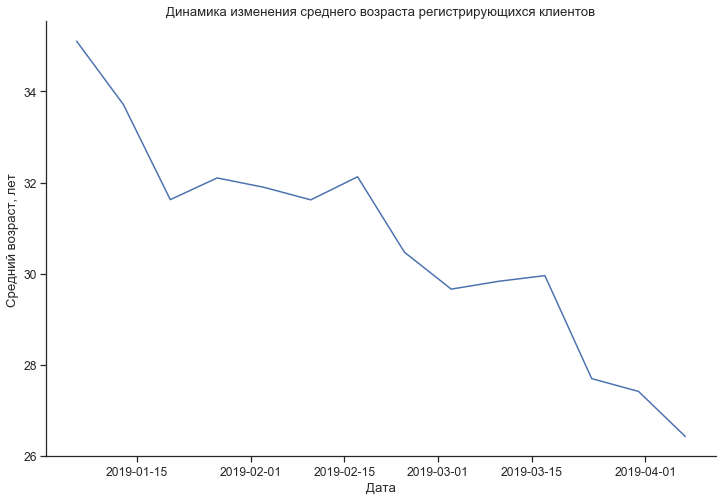

In [540]:
# отрисовываем график
sns.lineplot(data=df_age);

# оформление осей
plt.title('Динамика изменения среднего возраста регистрирующихся клиентов');
plt.xlabel('Дата');
plt.ylabel('Cредний возраст, лет');
sns.despine();

# сохраняем график
plt.savefig('avg_age.png')

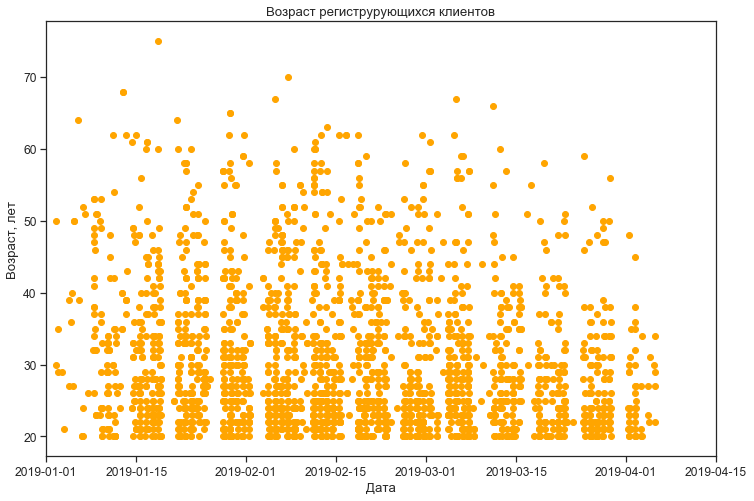

In [541]:
# отрисовываем график
plt.scatter(x=df['reg_dttm'],
            y=df['years'],
            color='orange');

# оформление осей
plt.xlabel('Дата');
plt.ylabel('Возраст, лет');
plt.title('Возраст региструрующихся клиентов');
plt.xlim(737060, 737164);

# сохраняем график
plt.savefig('avg_age_scatter.png')

#### Задание 2

Постройте диаграмму (или график), которая показывает, как по возрастным сегментам отличается конверсия в утилизацию.

In [542]:
# сегментация по возрастным группам
df['demographics'] = pd.cut(df.years, 
                            [19, 24, 34, 44, 54, 64, 1000],
                            labels = ['20-24', '25-34', '35-44', '45-54', '55-64', '65+'])

In [543]:
# отбираем уникальных клиентов для подсчета конверсии
df_uniq = df.drop_duplicates(subset=['client_id'])

In [544]:
# подсчитываем количество регистраций уникальными клиентами по возрастным группам
regs = df_uniq.groupby('demographics')['client_id'].nunique()

In [545]:
# подсчитываем количество утилизаций уникальными клиентами по возрастным группам
util = df_uniq[df['purchase_amt'] > 0] \
              .groupby('demographics')['client_id'].nunique()

/home/nktnlx/yes/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [546]:
# количество конверсий для lineplot
util_line = util.reset_index().rename(columns={'client_id': 'conversions'})

In [547]:
# считаем конверсию
cr = round((util / regs) * 100, 2).reset_index().rename(columns={'client_id': 'conversion_rate'})

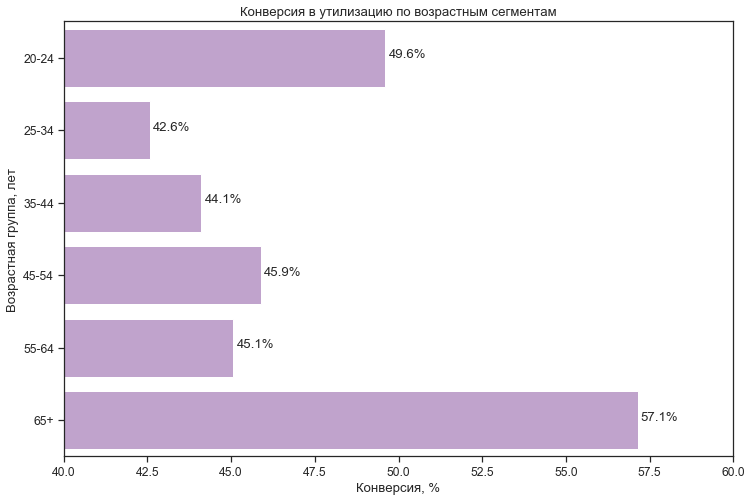

In [548]:
# отрисовываем график
ax = sns.barplot(y=cr.demographics, x=cr.conversion_rate, color='#C39CD3');

# оформление осей
plt.xlabel('Конверсия, %');
plt.ylabel('Возрастная группа, лет');
plt.title('Конверсия в утилизацию по возрастным сегментам');
plt.xlim(40, 60);

# добавляем подписи процентов
for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_width())
        x = p.get_x() + p.get_width() + 0.1
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
        
# сохраняем график
plt.savefig('convertion_by_demographics.png')

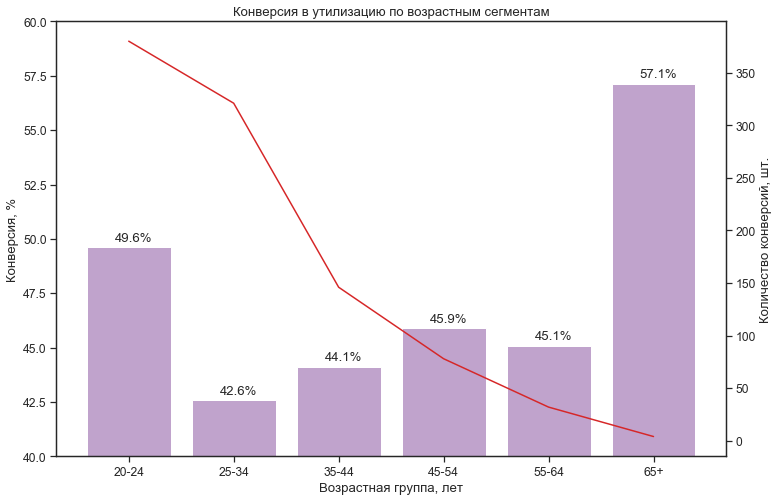

In [549]:
# отрисовываем график (столбчатая диаграмма convertion_rate)
ax = sns.barplot(x=cr.demographics, y=cr.conversion_rate, color='#C39CD3');

# оформление осей
plt.xlabel('Возрастная группа, лет');
plt.ylabel('Конверсия, %');
plt.title('Конверсия в утилизацию по возрастным сегментам');
plt.ylim(40, 60);

# добавляем подписи процентов
for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        x = p.get_x() + p.get_width() / 3
        y = p.get_y() + p.get_height() + 0.3
        ax.annotate(percentage, (x, y))

        
# добавляем второй график 
ax2 = ax.twinx()
color = 'tab:red'
# отрисовываем и оформляем второй график(линейный график количества конверсий в штуках)
ax2.set_ylabel('Количество конверсий, шт.')
ax2 = sns.lineplot(x='demographics', y='conversions', data = util_line, sort=False, color=color)
ax2.tick_params(axis='y')
      
        
# сохраняем график
plt.savefig('convertion_by_demographics_combo.png')

#### Задание 3

Постройте диаграмму (или график), которая показывает, как скорость утилизации влияет на размер первой покупки.

In [702]:
# оставляем клиентов только с утилизацией
df_util = df.dropna(subset=['purchase_dt'])

In [703]:
# подсчет времени с момента регистрации до момента утилизации в днях
df_util['idle_time'] = df_util['purchase_dt'] - df_util['reg_dttm'].dt.floor('d')

/home/nktnlx/yes/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [704]:
# отбираем только первые утилизации
df_util_uniq = df_util.drop_duplicates(subset=['client_id'], keep='first')

In [705]:
# cчитаем средний чек и количество утилизаций
df_idle = df_util_uniq.groupby('idle_time').agg({'purchase_amt': ['mean', 'count']})
# сброс индекса для удобства
df_idle.reset_index(inplace=True)

In [706]:
# переводим дни в отдельную колонку
df_idle['days'] = df_idle.idle_time.dt.days

In [707]:
# убираем мультииндекс из колонок после агрегации
df_idle.columns=df_idle.columns.map('_'.join)

In [708]:
# удаляем лишнюю колонку
df_idle.drop(columns='idle_time_', inplace=True)

# даем колонкам "хорошие" имена
df_idle.rename(columns={'purchase_amt_mean': 'purchase_mean',
                                                  'purchase_amt_count': 'purchases',
                                                  'days_': 'idle_days'}, inplace=True)

In [709]:
# округляем до двух знаков значения в столбце purchase_mean
df_idle['purchase_mean'] = df_idle.purchase_mean.apply(lambda x: round(x, 2))

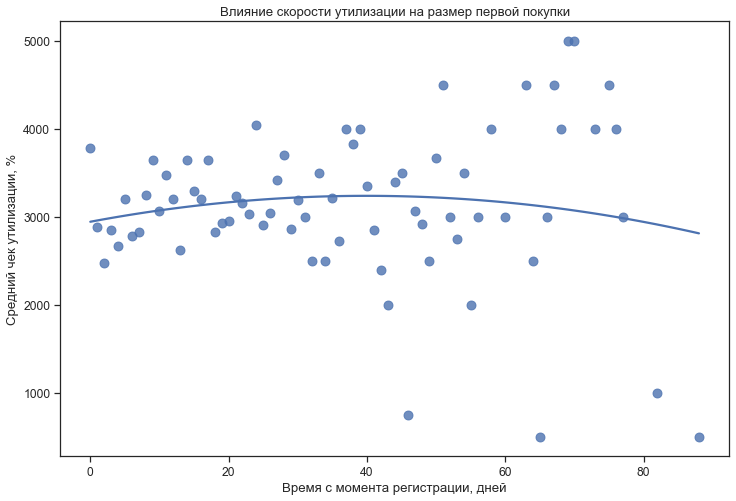

In [710]:
# отрисовываем график (точечная диаграмма с полиномиальной линией регрессии)
sns.regplot(data=df_idle, x='idle_days', y='purchase_mean',
            scatter_kws={"s": 80}, order=2, ci=None);

# оформление осей
plt.xlabel('Время с момента регистрации, дней');
plt.ylabel('Средний чек утилизации, %');
plt.title('Влияние скорости утилизации на размер первой покупки');

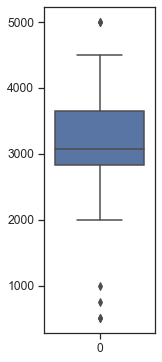

In [711]:
# визуально определяем выбросы значений
plt.figure(figsize=(2, 6))
sns.boxplot(data=df_idle.purchase_mean);

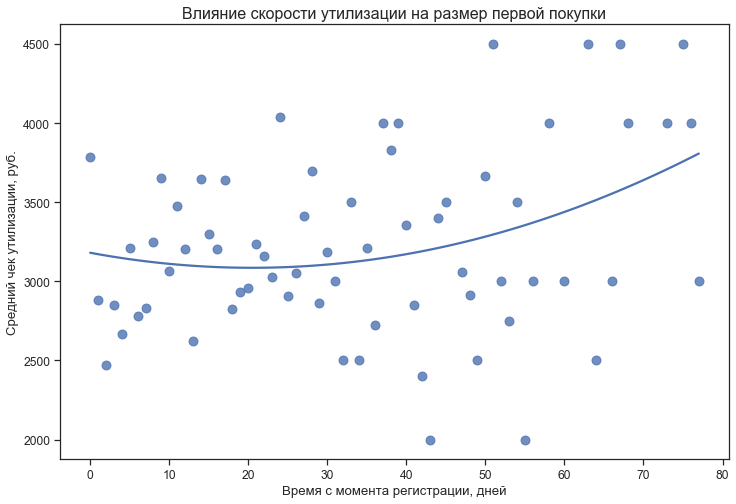

In [712]:
# отрисовываем график (точечная диаграмма с полиномиальной линией регрессии)
# убираем выбросы (за пределами 1.5*IQR)
sns.regplot(data=df_idle[(df_idle['purchase_mean'] > 1500) & (df_idle['purchase_mean'] < 5000)],
            x='idle_days', y='purchase_mean',
            scatter_kws={"s": 80}, order=2, ci=None);

# оформление осей
plt.xlabel('Время с момента регистрации, дней');
plt.ylabel('Средний чек утилизации, руб.');
plt.title('Влияние скорости утилизации на размер первой покупки', fontdict={'fontsize': 16});

# сохраняем график
plt.savefig('mean_check_vs_util.png')